In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [40]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

In [91]:
# Generating the network
n_nodes = 6
rate = 1.
T = 50
dt = 0.01
train_sample = 200000
val_sample = 10000
approach = "completeMethod"

# graph = complete_graph(n_nodes)
graph = chain_graph(n_nodes)

# Generating the dataset
transform = [dl.SIS_StateToFloat()]
train_dataset = dl.SISDataset(rate)
val_dataset = dl.SISDataset(rate)
train_dataset.generate(graph, train_sample, T, init_active=0.01, dt=dt, pre_transform=transform)
val_dataset.generate(graph, val_sample, T, init_active=0.01, dt=dt, pre_transform=transform)

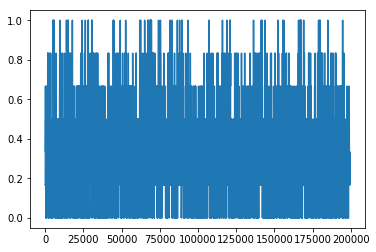

In [92]:
def show_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_dataset(train_dataset)
plt.plot(avg)
plt.show()

In [93]:
n_hidden = [128, 64]
n_embedding = n_nodes
keepprob = 0.9
lr = 1e-2
wd = 1e-3
optimizer = lambda p: torch.optim.Adam(p, lr=lr, weight_decay=wd)
loss = torch.nn.BCELoss(reduction='none')
scheduler = lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=10, factor=0.2)
use_cuda = torch.cuda.is_available()

model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding,
                                  keepprob=keepprob, optimizer=optimizer, loss=loss, scheduler=scheduler,
                                  use_cuda=use_cuda)

In [94]:
model.fit(train_dataset,
          val_dataset=val_dataset,
          epochs=100,
          batch_size=128,
          verbose=True,
          keep_best=True,
          training_metrics=['loss', 'recon', 'kl_div'],
          model_metrics=['lr'],
          show_var=False,
          beta=1)

New best Epoch: 0 - Time: 0.00
	 Train. - loss: 3.6868, recon: 0.6898, kl_div: 2.9969, 
	 Val. - loss: 3.6841, recon: 0.6891, kl_div: 2.9950, 
New best Epoch: 1 - Time: 25.00, lr: 0.01
	 Train. - loss: 0.1020, recon: 0.1017, kl_div: 0.0003, 
	 Val. - loss: 0.1137, recon: 0.1133, kl_div: 0.0003, 
New best Epoch: 2 - Time: 21.62, lr: 0.01
	 Train. - loss: 0.0957, recon: 0.0955, kl_div: 0.0003, 
	 Val. - loss: 0.1019, recon: 0.1016, kl_div: 0.0003, 
New best Epoch: 3 - Time: 21.76, lr: 0.01
	 Train. - loss: 0.0989, recon: 0.0987, kl_div: 0.0002, 
	 Val. - loss: 0.0955, recon: 0.0953, kl_div: 0.0002, 
New best Epoch: 4 - Time: 21.71, lr: 0.01
	 Train. - loss: 0.0936, recon: 0.0935, kl_div: 0.0002, 
	 Val. - loss: 0.0952, recon: 0.0950, kl_div: 0.0002, 
New best Epoch: 5 - Time: 21.83, lr: 0.01
	 Train. - loss: 0.0912, recon: 0.0909, kl_div: 0.0003, 
	 Val. - loss: 0.0934, recon: 0.0931, kl_div: 0.0003, 
Epoch: 6 - Time: 21.82, lr: 0.01
Epoch: 7 - Time: 21.83, lr: 0.01
New best Epoch: 8 - T

KeyboardInterrupt: 

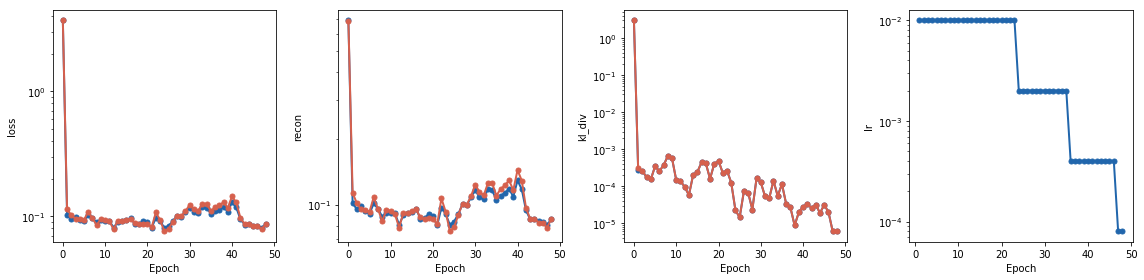

In [95]:
fig, ax = plt.subplots(1, 4,figsize=(16, 4))
_ax = {}
metrics = ['loss', 'recon', 'kl_div', 'lr']
for i, m in enumerate(metrics):
#     ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    _ax[m] = ax[i]

model.history.plot(training_metrics = ['loss', 'recon', 'kl_div'], model_metrics=['lr'],ax=(fig,_ax))
plt.tight_layout()
plt.show()

In [96]:
def reconstruct_TS(graph, model, dataset, time_step, dt):
    transform = [dl.SIS_StateToFloat()]
    t = 0
    past = dataset[0][0].numpy()
    real_ts = []
    learned_ts = []
    while(t < time_step):
        t += 1
        real_prob = dataset.get_transition_probability(graph, past, dt)
        past = torch.tensor(past).float()
        learned_prob, _, _ = model.predict(past, batch_size=128)
        learned_prob = np.mean(learned_prob, 0)
        learned_present = torch.bernoulli(torch.tensor(learned_prob)).numpy()
        real_present = torch.bernoulli(torch.tensor(learned_prob)).numpy()
        learned_ts.append(learned_present)
        real_ts.append(real_present)
        past = real_present
    
    return np.array(real_ts), np.array(learned_ts)
        
        
        


In [97]:
real, learned = reconstruct_TS(graph, model, train_dataset, 2000, dt)
print(real.shape, learned.shape)
real_TS, learned_TS = np.mean(real, 1), np.mean(learned, 1)
print(real_TS.shape, learned_TS.shape)

(2000, 6) (2000, 6)
(2000,) (2000,)


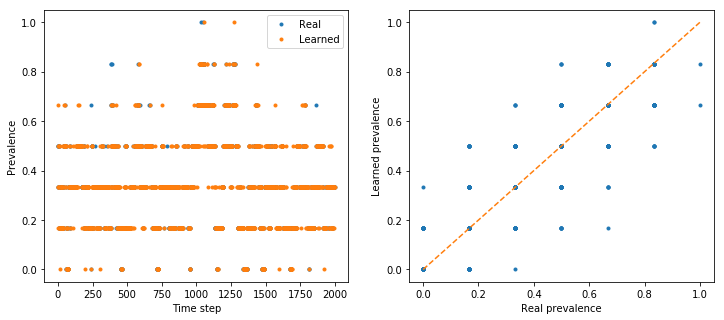

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real_TS, '.', label='Real')
ax[0].plot(learned_TS, '.', label='Learned')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')
ax[0].legend()

ax[1].plot(real_TS, learned_TS, '.')
ax[1].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Learned prevalence')
plt.show()

In [99]:
all_states = train_dataset.enumerate_all_states(graph)
markovProb = np.zeros([len(all_states), len(all_states)])

for i, past in enumerate(all_states):
    prob = train_dataset.get_transition_probability(graph, past, dt)
    for j, present in enumerate(all_states):
        present_prob = present * prob + (1 - present) * (1 - prob)
        markovProb[i, j] = np.prod(present_prob)
markovProb[markovProb == 0] = 1e-50
markovProb /= np.sum(markovProb, 0)

In [100]:
learnedProb = np.zeros([len(all_states), len(all_states)])
for i, past in enumerate(all_states):
    _past = torch.tensor(past).float()
    prob, _, _ = model.predict(_past, batch_size=2)
    avg_prob = np.mean(prob, 0)
    for j, present in enumerate(all_states):
        present_prob = present * avg_prob + (1 - present) * (1 - avg_prob)
        learnedProb[i, j] = np.prod(present_prob)

learnedProb[learnedProb < 1e-50] = 1e-50
        
learnedProb /= np.sum(learnedProb, 0)



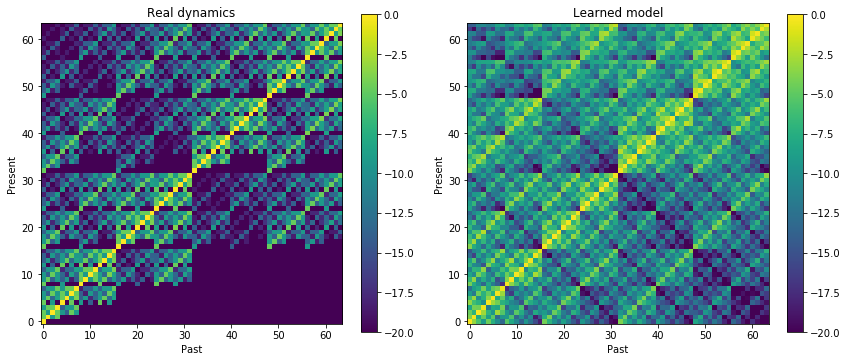

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cs = ax[0].imshow(np.log(markovProb), origin='lower', vmin=-20, vmax=0)
# ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')
ax[0].set_title('Real dynamics')
plt.colorbar(cs, ax=ax[0])

ax[1].imshow(np.log(learnedProb), origin='lower', vmin=-20, vmax=0)
# ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')
ax[1].set_ylabel('Present')
ax[1].set_title('Learned model')
plt.colorbar(cs, ax=ax[1])
plt.tight_layout()

figname = "{0}_trans_{1}_rate{2}_dt{3}".format(approach, graph.name, rate, dt)
fig.savefig("fig/png/" + figname + ".png")
fig.savefig("fig/pdf/" + figname + ".pdf")

plt.show()